# Nutation and Precession of a gyroscope

From the IB Dynamics course, the [equations of motion for a symmetric top](http://www-teach.phy.cam.ac.uk/dms/dms_getFile.php?node=9980) can be written as:

$$
\frac{1}{2}I_1 \dot{\theta}^2 = E - \frac{(J_z-J_3 \cos \theta)^2}{2I_1 \sin^2 \theta} - mgh\cos\theta - \frac{J_3^2}{2I_3}
$$

$$
I_1\ddot{\theta} = mgh\sin\theta-\frac{J_3(J_z-J_3 \cos \theta)}{I_1 \sin \theta}+\frac{(J_z-J_3 \cos \theta)^2\cos\theta}{I_1 \sin^3\theta}
$$

$$
\dot{\phi} = \frac{J_z-J_3 \cos \theta}{I_1 \sin^2 \theta}
$$

$$
\dot{\chi} = \frac{J_3}{I_3}+\frac{J_3\cos^2\theta-J_z\cos\theta}{I_1 \sin^2\theta}
$$

By integrating the second equation, which is the time derivative of the first, to find $\dot{\theta}$, the angle $\theta(t)$ can be found and this can be used to integrate both $\chi$ and $\phi$.

First suitable values for the free parameters must be found. By writing the energy equation as the following:

$$
\frac{1}{2}I_1 \dot{\theta}^2 = E - \frac{(J_z-J_3 \cos \theta)^2}{2I_1 \sin^2 \theta} - mgh\cos\theta - \frac{J_3^2}{2I_3} = E - U_{eff}(\theta)
$$

The effective potential can be used to find the range of $\theta$ values for a given energy.

In [1]:
import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib.animation import FuncAnimation
%matplotlib inline

from pycav import display

E = 71.
# I_1 and I_3
I = [0.1,0.05]
# J_z and J_3
J = [2.,2.5]
m = 1.
h = 1.

def Ueff(theta,I,J,m,h):
    return (J[0]-J[1]*np.cos(theta))**2/(2*I[0]*(np.sin(theta))**2)+m*9.81*h*np.cos(theta)+J[1]**2/(2*I[1])

## Effective Potential plot

By looking at the plot below, one can find the maximum and minimal values of $\theta$ for the given energy value, $E$.

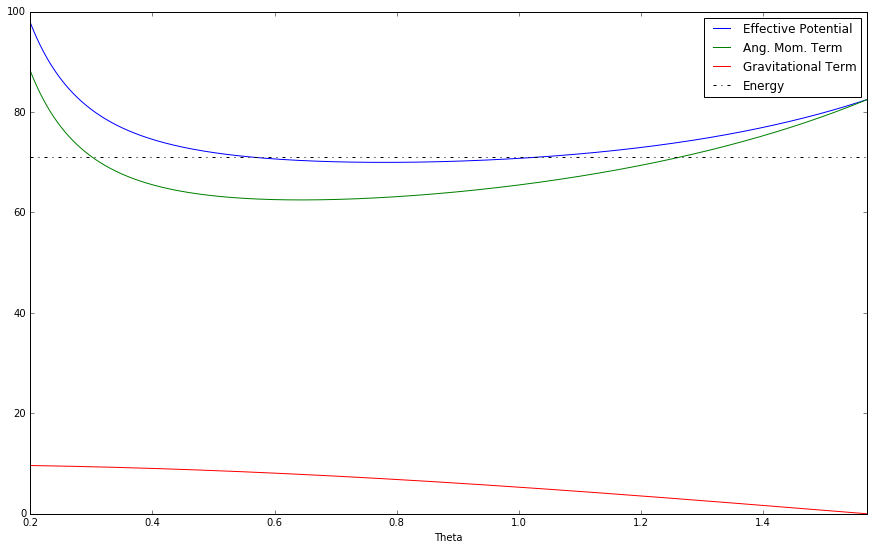

In [2]:
theta = np.linspace(0.2,np.pi/2.,1000)
fig1 = plt.figure(figsize = (15,9));
ax1  = fig1.add_subplot(111);
ax1.plot(theta,Ueff(theta,I,J,m,h));
ax1.plot(theta,(J[0]-J[1]*np.cos(theta))**2/(2*I[0]*(np.sin(theta))**2)+J[1]**2/(2*I[1]));
ax1.plot(theta,m*9.81*h*np.cos(theta));
ax1.axhline(E,c = 'k',ls = '-.');
ax1.set_xlim((theta.min(),theta.max()));
ax1.set_xlabel('Theta');
ax1.legend(('Effective Potential','Ang. Mom. Term','Gravitational Term','Energy'));

## Using odeint from SciPy to numerically integrate our equations of motion

With suitable free parameters chosen, the equations can be integrated using SciPy's odeint function to give us the angles as functions of time

Here we define $\omega = \dot{\theta}$ so the set of first order differential equations we are solving are:

$$
\dot{\omega} = \frac{1}{I_1} \left( mgh\sin\theta-\frac{J_3(J_z-J_3 \cos \theta)}{I_1 \sin \theta}+\frac{(J_z-J_3 \cos \theta)^2\cos\theta}{I_1 \sin^3\theta} \right)
$$

$$
\dot{\theta} = \omega
$$

$$
\dot{\phi} = \frac{J_z-J_3 \cos \theta}{I_1 \sin^2 \theta}
$$

$$
\dot{\chi} = \frac{J_3}{I_3}+\frac{J_3\cos^2\theta-J_z\cos\theta}{I_1 \sin^2\theta}
$$

odeint takes a list of starting values, [$\omega_0$, $\theta_0$, $\phi_0$, $\chi_0$], and takes a function which returns a list of the time derivatives, [$\dot{\omega}$, $\dot{\theta}$, $\dot{\phi}$, $\dot{\chi}$], and returns a list containing the input variables evaluated at the times given, [$\omega(t)$, $\theta(t)$, $\phi(t)$, $\chi(t)$]


In [3]:
def omega_dot(theta,E,I,J,m,h):
    return (1/I[0])*(m*9.81*h*np.sin(theta)-
                     (J[1]*(J[0]-J[1]*np.cos(theta)))/(I[0]*np.sin(theta))+
                     (J[0]-J[1]*np.cos(theta))**2*np.cos(theta)/(I[0]*(np.sin(theta))**3))

def theta_dot(theta,E,I,J,m,h):
    rot_energy = E-Ueff(theta,I,J,m,h)
    return np.sqrt(2*rot_energy/I[0])

def phi_dot(theta,E,I,J,m,h):
    return (J[0]-J[1]*np.cos(theta))/(I[0]*(np.sin(theta))**2)

def chi_dot(theta,E,I,J,m,h):
    return (J[1]*(np.cos(theta))**2-J[0]*np.cos(theta))/(I[0]*(np.sin(theta))**2)+J[1]/I[1]

def derivatives(q,t,E,I,J,m,h):
    omega = q[0]
    theta = q[1]
    dqdt = [omega_dot(theta,E,I,J,m,h),omega,phi_dot(theta,E,I,J,m,h),chi_dot(theta,E,I,J,m,h)]
    return dqdt

starting_angles = [0.8,0.,0.]
q0 = [theta_dot(starting_angles[0],E,I,J,m,h),starting_angles[0],starting_angles[1],starting_angles[2]]
t = np.linspace(0.,3.5,500)

sol = odeint(derivatives,q0,t,args = (E,I,J,m,h))

## Plotting the motion of the gyroscope

Converting these angles into Cartesian coordinates allows us to plot the trajectory of the centre of the mass

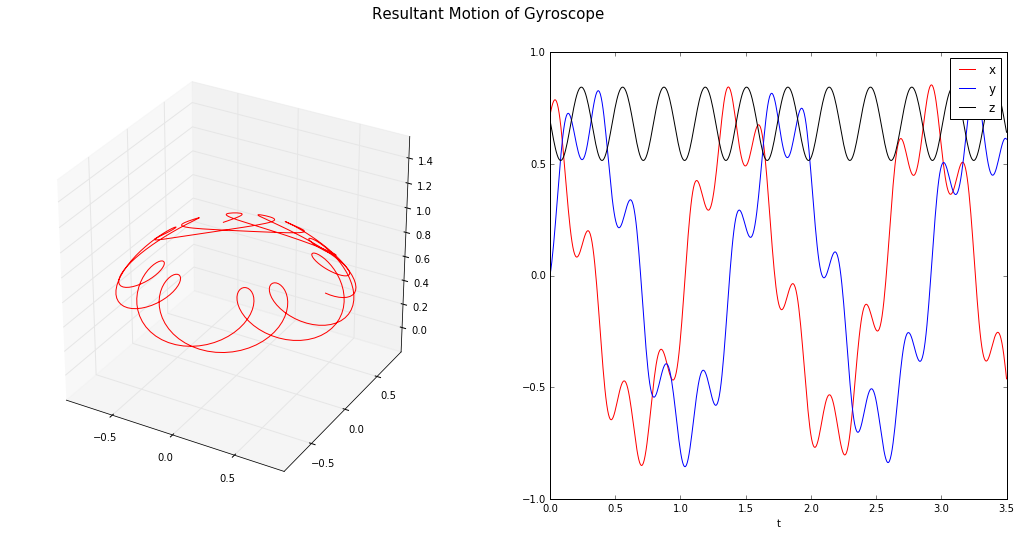

In [4]:
theta = sol[:,1]
phi   = sol[:,2]
chi   = sol[:,3]

x,y,z = h*np.sin(theta)*np.cos(phi),h*np.sin(theta)*np.sin(phi),h*np.cos(theta)

# Create cubic bounding box to simulate equal aspect ratio
max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
Xb = 0.5*max_range*np.array((-1.,1.)) + 0.5*(x.max()+x.min())
Yb = 0.5*max_range*np.array((-1.,1.)) + 0.5*(y.max()+y.min())
Zb = 0.5*max_range*np.array((-1.,1.)) + 0.5*(z.max()+z.min())

fig2 = plt.figure(figsize = (18,8));
fig2.suptitle('Resultant Motion of Gyroscope', fontsize = 15);
ax2 = fig2.add_subplot(121, projection='3d');
ax2.set_aspect('equal');
ax2.set_xlim3d((Xb[0],Xb[-1]));
ax2.set_ylim3d((Yb[0],Yb[-1]));
ax2.set_zlim3d((Zb[0],Zb[-1]));

ax2.plot(x,y,z,'r');

ax3 = fig2.add_subplot(122);
ax3.plot(t,x,'r');
ax3.plot(t,y,'b');
ax3.plot(t,z,'k');
ax3.legend(('x','y','z'));
ax3.set_xlabel('t');


## Animating this behaviour

In [5]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize = (12,12));
ax = fig.add_subplot(111, projection='3d');
ax.set_aspect('equal');

qx    = 0.5*x+0.1*h*(np.cos(theta)*np.cos(phi)*np.cos(chi)-np.sin(phi)*np.sin(chi))
qy    = 0.5*y+0.1*h*(np.cos(theta)*np.sin(phi)*np.cos(chi)+np.cos(phi)*np.sin(chi))
qz    = 0.5*z+0.1*h*(-np.sin(theta)*np.cos(chi))

def nextframe(arg):
    n = arg*2
    ax.clear()
    ax.plot([0.5*x[n],qx[n]],[0.5*y[n],qy[n]],[0.5*z[n],qz[n]],'k-',lw = 3)
    a = Arrow3D([0., x[n]], [0., y[n]], 
                [0., z[n]], mutation_scale=20, 
                lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
    ax.plot(x[:n],y[:n],z[:n],'r')
    ax.set_xlim3d((Xb[0],Xb[-1]))
    ax.set_ylim3d((Yb[0],Yb[-1]))
    ax.set_zlim3d((Zb[0],Zb[-1]))

animate = FuncAnimation(fig,nextframe, interval = 75, frames = int(len(t)/2), repeat = False)
animate = display.create_animation(animate, temp = True)
display.display_animation(animate)